In [1]:
import numpy as np
import matplotlib.pyplot as pyplot
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## Data Processing

In [2]:
##Data Aquisition
me = np.load('LO_3_0.01/NJ_LO_3_0.01_500000.npy', allow_pickle=True) #Matrix elements
momentum_raw = np.load('LO_3_0.01/PS3_0.01_500000.npy', allow_pickle=True, encoding='bytes') #4-momenta of input states

In [ ]:
##Reformat Momentum
momentum = np.array([np.ndarray.flatten(np.array(element[3:])) for element in momentum_raw]) #flattening 3x4-vectors into a single vector - machine doesn't care about the physics)

##Shuffle Data
s = np.arange(len(me)) #Indexing array (0 to len(me)-1)
np.random.shuffle(s) #Shuffle the indexing array
#Use the fact that numpy arrays can be indexed by arrays to shuffle in unison.
me = me[s] 
momentum = momentum[s]

In [ ]:
##Split into train & test set (2/3 train, 1/3 test)
momentum_train, momentum_test, me_train, me_test = train_test_split(momentum, me, test_size=0.33, random_state=42)

In [ ]:
##Data Transformation
scaler = StandardScaler()

momentum_train_prep = scaler.fit_transform(momentum_train) 
momentum_test_prep = scaler.transform(momentum_test) 

## Machine Learning

Linear Model:

In [8]:
##Linear Model
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
linreg.fit(momentum_train_prep, me_train) #Fit Linear model

me_predict_lin = linreg.predict(momentum_test_prep) #Prediction on test set
lin_mse = mean_squared_error(me_test, me_predict_lin) 
print(np.sqrt(lin_mse))

0.7435923063739814


Random Forest Model:

In [ ]:
##Random Forest Model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

param_grid = {'n_estimators': [10], 'max_features': [2] }

forest_reg = RandomForestRegressor() 

#Grid search through parameter space
rand_search = RandomizedSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', return_train_score=True)
rand_search.fit(momentum_train_prep, me_train)

me_predict = rand_search.predict(momentum_test_prep)
forest_mse = mean_squared_error(me_test, me_predict)
print(np.sqrt(forest_mse))

/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [1]:
##Best estimator
cvres=rand_search.cv_results_
for mean_score,params in zip(cvres['mean_test_score'], cvres['params']):
    print(np.sqrt(-mean_score), params)

NameError: name 'rand_search' is not defined

In [9]:
##Plotting a Learning Curve
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
        linreg, momentum_train_prep, me_train, n_jobs=6, cv=5)

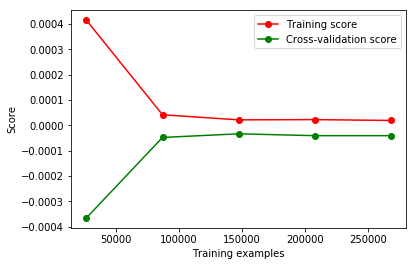

In [10]:
pyplot.figure()

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)


pyplot.xlabel("Training examples")
pyplot.ylabel("Score")
pyplot.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
pyplot.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

pyplot.legend(loc="best")

Polynomial Fit:

In [3]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import ElasticNet

poly_features = PolynomialFeatures(degree=1)
momentum_poly = poly_features.fit_transform(momentum_train_prep)
momentum_poly_test = poly_features.transform(momentum_test_prep)

elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5)
elasticnet.fit(momentum_poly, me_train)

me_predict = elasticnet.predict(momentum_poly_test)
poly_mse = mean_squared_error(me_test, me_predict)
print(np.sqrt(poly_mse))

NameError: name 'momentum_train_prep' is not defined

In [53]:
from sklearn.model_selection import validation_curve
alphas = np.logspace(-3, -1.5, 10)
l1_ratio = np.logspace(-3, 1, 6)
train_scores, valid_scores = validation_curve(ElasticNet(alpha=0.1,), momentum_poly, me_train, "l1_ratio",
                                              l1_ratio,
                                              cv=5)

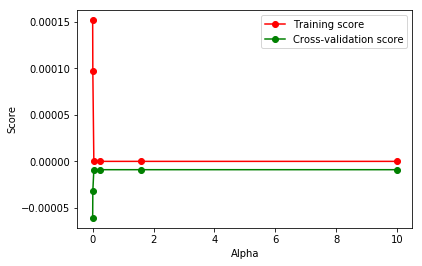

In [55]:
pyplot.figure()

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(valid_scores, axis=1)

pyplot.xlabel("Alpha")
pyplot.ylabel("Score")
pyplot.plot(l1_ratio, train_scores_mean, 'o-', color="r",
             label="Training score")
pyplot.plot(l1_ratio, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

pyplot.legend(loc="best")